In [1]:
# Making necessary imports
# To supress tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
with open("../input/nepali65ksentences/data.txt", "r", encoding='utf-8-sig') as f:
    text = f.read()
    
# Viewing a portion of the original text
text[:500]

'"अब गाह्रो छैन प्रदूषण नाप्न भारतीय पूर्व प्रधानमन्त्रीलाई उपप्रधानमन्त्री निधीले किन भेटे"\n"लाठी लिएका हजारौँ संख्यामा रहेका थारुहरुले र्याली प्रर्दशन गरी राजापुर बजारको दक्षिण चौकमा कोणसभा गरेका थिए"\n"आफूहरुले आफनो स्वाभिमानको लडाइ लडेको उनको भनाई थियो"\n"प्रदर्शनकारीले प्रहरी दमन बन्द गर, कैलाली कञ्चनपुर छाड्दैनौँ , प्रतिगमनकारी होसियार जस्ता नारा लगाएका थिए"\n"भारतको अघोषित नाकाबन्दीका कारण पेट्रोलियम पदार्थको अभाव भएपछि सर्वसाधारणले जोखिमपूर्ण यात्रा गर्नुपर्ने बाध्यता बढेको छ"\n"पेट्रोलियम पद'

In [3]:
# Some basic preprocessing

text = " ".join(text.split()) # Remove any remaining white spaces
text = text.replace('"', '').replace("'", '') # Remove single and double quotation marks

# Viewing a portion of the preprocessed text
text[:500]

'अब गाह्रो छैन प्रदूषण नाप्न भारतीय पूर्व प्रधानमन्त्रीलाई उपप्रधानमन्त्री निधीले किन भेटे लाठी लिएका हजारौँ संख्यामा रहेका थारुहरुले र्याली प्रर्दशन गरी राजापुर बजारको दक्षिण चौकमा कोणसभा गरेका थिए आफूहरुले आफनो स्वाभिमानको लडाइ लडेको उनको भनाई थियो प्रदर्शनकारीले प्रहरी दमन बन्द गर, कैलाली कञ्चनपुर छाड्दैनौँ , प्रतिगमनकारी होसियार जस्ता नारा लगाएका थिए भारतको अघोषित नाकाबन्दीका कारण पेट्रोलियम पदार्थको अभाव भएपछि सर्वसाधारणले जोखिमपूर्ण यात्रा गर्नुपर्ने बाध्यता बढेको छ पेट्रोलियम पदार्थ पाउन छ'

In [4]:
# Apply Tokenization

# Fitting tokenizer on text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

# View what the tokenizer has learned
vocab_size = len(tokenizer.word_index)+1
print(f'Total number of unique words: {vocab_size}\n')
print(f"Word Count: {list(tokenizer.word_counts.items())[:5]}\n")
print(f"Document Count: {tokenizer.document_count}\n")
print(f"Word Index: {dict(list(tokenizer.word_index.items())[:5])}")

# Saving the tokenizer
pickle.dump(tokenizer, open("./tokenizer_nepali.pkl", 'wb'))

Total number of unique words: 10648

Word Count: [('अब', 34), ('गाह्रो', 4), ('छैन', 11), ('प्रदूषण', 1), ('नाप्न', 1)]

Document Count: 1

Word Index: {'छ': 1, 'र': 2, 'भएको': 3, 'पनि': 4, 'गरेको': 5}


In [5]:
# Transforming text to sequences
sequence_data = tokenizer.texts_to_sequences([text])[0]
print(f'Length of sequence data: {len(sequence_data)}')
print(sequence_data[:5])

Length of sequence data: 32863
[89, 1184, 404, 3736, 3737]


In [6]:
# Creating sequences each having 4 words (first three words are used to predict the fourth word)
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)

sequences = np.array(sequences)
print(f'Total number of sequences: {sequences.shape[0]}')
sequences[:5]

Total number of sequences: 32860


array([[  89, 1184,  404, 3736],
       [1184,  404, 3736, 3737],
       [ 404, 3736, 3737,  118],
       [3736, 3737,  118,  405],
       [3737,  118,  405, 1556]])

In [7]:
# Taking first 3 words as input and last word as output

X = sequences[:,0:3]
y = sequences[:,3]

# Converting output into binary class matrix
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# Creating a LSTM model

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             106480    
_________________________________________________________________
lstm (LSTM)                  (None, 3, 256)            273408    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 10648)             1373592   
Total params: 2,311,688
Trainable params: 2,311,688
Non-trainable params: 0
______________________________________________

In [9]:
# Training the model

checkpoint = ModelCheckpoint("./model.h5", monitor="loss", verbose=1, save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001))

In [10]:
history = model.fit(X,
          y,
          epochs=150,
          batch_size=64,
          validation_split=0.2,
          callbacks=[checkpoint, reduce])

Epoch 1/150
411/411 [==============================] - 9s 10ms/step - loss: 8.5376 - val_loss: 8.4494

Epoch 00001: loss improved from inf to 8.53763, saving model to ./model.h5
Epoch 2/150
411/411 [==============================] - 3s 7ms/step - loss: 8.0304 - val_loss: 8.6942

Epoch 00002: loss improved from 8.53763 to 8.03041, saving model to ./model.h5
Epoch 3/150
411/411 [==============================] - 4s 9ms/step - loss: 7.8405 - val_loss: 8.9505

Epoch 00003: loss improved from 8.03041 to 7.84049, saving model to ./model.h5
Epoch 4/150
411/411 [==============================] - 3s 7ms/step - loss: 7.5874 - val_loss: 9.1827

Epoch 00004: loss improved from 7.84049 to 7.58739, saving model to ./model.h5
Epoch 5/150
411/411 [==============================] - 3s 7ms/step - loss: 7.3478 - val_loss: 9.5348

Epoch 00005: loss improved from 7.58739 to 7.34780, saving model to ./model.h5
Epoch 6/150
411/411 [==============================] - 3s 8ms/step - loss: 7.1171 - val_loss: 9.86

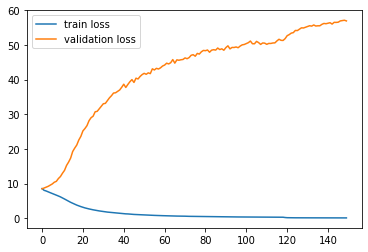

<Figure size 432x288 with 0 Axes>

In [11]:
# Plotting losses and accuracies on each epochs

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')